In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

Q1a) What are probabilities and payout rates pregame?

In [2]:
lambda_ = np.random.uniform(0.8, 1.2, size=100000)
fh = np.random.poisson(lambda_)
sh = np.random.poisson(lambda_)
total = fh + sh

In [3]:
print("Goals\tprob\trate")
for i in range(0, 7):
    p = (total == i).mean()
    print(f"{i}\t{p:.4f}\t{0.99 / p:.2f}")

Goals	prob	rate
0	0.1387	7.14
1	0.2697	3.67
2	0.2680	3.69
3	0.1780	5.56
4	0.0906	10.93
5	0.0377	26.27
6	0.0124	80.03


Q1b) Observe fh=0

In [4]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    lambda_ = pm.Uniform("lambda_", lower=0.8, upper=1.2)
    sh = pm.Poisson("sh", mu=lambda_)

    # observations
    fh = pm.Poisson("fh", mu=lambda_, observed=0)

    #total
    total = pm.Deterministic('total', fh + sh)

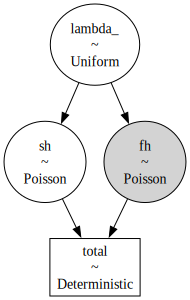

In [5]:
pm.model_to_graphviz(model)

In [6]:
with model:
    trace = pm.sample(draws=20000, tune=1000, chains=4, random_seed=0)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_]
>Metropolis: [sh]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 25 seconds.


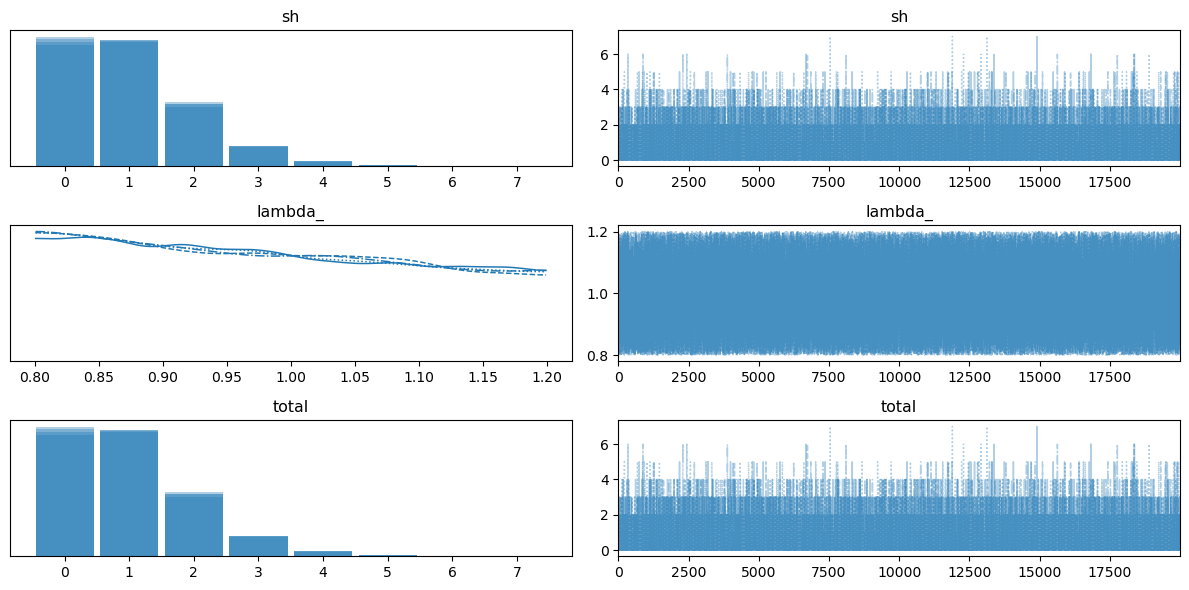

In [7]:
with model:
    az.plot_trace(trace)
    plt.tight_layout()

In [8]:
with model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sh,0.993,0.999,0.0,3.000,0.009,0.006,13763.0,16751.0,1.0
lambda_,0.987,0.115,0.8,1.171,0.001,0.000,30920.0,40562.0,1.0
total,0.993,0.999,0.0,3.000,0.009,0.006,13763.0,16751.0,1.0


In [12]:
totalsamples = (trace['posterior']['total']).to_numpy()
print("Goals\tprob\trate")
for i in range(0, 8):
    p = (totalsamples == i).mean()
    print(f"{i}\t{p:.4f}\t{0.99 / p:.2f}")

for i in range(0, 8):
    p = (totalsamples == i).mean()
    p_not = (totalsamples != i).mean()
    print(p, p_not, p + p_not, (p_not - 0.01) / p)
    pass

Goals	prob	rate
0	0.3698	2.68
1	0.3695	2.68
2	0.1827	5.42
3	0.0590	16.78
4	0.0149	66.55
5	0.0035	279.86
6	0.0006	1650.00
7	0.0001	9900.00
0.369775 0.630225 1.0 1.6773037658035292
0.36945 0.63055 1.0 1.679658952496955
0.1826625 0.8173375 1.0 4.4198316567439955
0.059 0.941 1.0 15.779661016949152
0.014875 0.985125 1.0 65.5546218487395
0.0035375 0.9964625 1.0 278.85865724381625
0.0006 0.9994 1.0 1649.0
0.0001 0.9999 1.0 9899.0


Q3

In [35]:
def Ufunc(x):
    return np.where(x < 0, 0 + (0.42 / 30) * x,
                    np.where(x < 35, 0.42 + ((0.75 - 0.42) / 35) * x,
                             0.75 + (1 - 0.75) / (70 - 35) * x
                             ))

In [36]:
#Policy 1. No Market Research, Invest
Q = np.random.uniform(0, 10, size=1000000)
X = 10 * (7 - Q)
U = Ufunc(X)
U.mean()

0.5351728011905615

In [37]:
#Policy 2. Market Research doesn't follow the advice - definitely not good

In [38]:
#Policy 3. Market Research. Follow advice
Q = np.random.uniform(0, 10, size=1000000)
R = np.random.binomial(n=1, p=(10 - Q) / 10)  #bernoulli is binomial with n=1

X = np.where(R > 0.5,
             10 * (7 - Q) - 1,
             -1)
U = Ufunc(X)
U.mean()

# 1000000
# 1000000

0.40787381442329496

In [39]:
R

array([1, 1, 1, ..., 0, 1, 1])

Q3b) What is E[U | R=1]

In [40]:
def UfuncPyMC(x):
    return pm.math.where(x < 0, 0 + (0.42 / 30) * x,
                         pm.math.where(x < 35, 0.42 + ((0.75 - 0.42) / 35) * x,
                                       0.75 + (1 - 0.75) / (70 - 35) * x
                                       ))

In [41]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    Q = pm.Uniform("Q", lower=0, upper=10)
    # observations
    R = pm.Bernoulli("R", p=(10 - Q) / 10, observed=1)

    X = pm.Deterministic("X", 10 * (7 - Q) - 1)
    U = pm.Deterministic("U", UfuncPyMC(X))

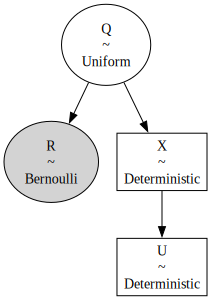

In [42]:
pm.model_to_graphviz(model)

In [43]:
with model:
    trace = pm.sample(draws=20000, tune=1000, chains=4, random_seed=0, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 24 seconds.


In [44]:
(trace['U']).mean()

0.828773040680603

In [45]:
trace['X']

array([67.32861369, 67.17067171, 62.71090364, ...,  1.79244659,
       57.75120444, 29.79558597])

In [46]:
s = [Ufunc(i) for i in trace['X']]

In [47]:
s = np.array(s)
s.mean()

0.828773040680603